## Setup

In [68]:
from modules.quicklook.src.analyze_time_series import AnalyzeTimeSeries
import pandas as pd
import matplotlib.pyplot as plt
#import os
import numpy as np
import time
#import subprocess
#import matplotlib.dates as mdates
from datetime import datetime
#from astropy.table import Table
%matplotlib inline

import sqlite3

In [69]:
# files stored locally at /data/user/jspencermorris/testdata
db_path = '/testdata/kpf_ts_oct2024_v2.db' # name of database file
myTS = AnalyzeTimeSeries(db_path=db_path) # build database

# import the test timeseries database
myTS = AnalyzeTimeSeries(db_path=db_path)

INFO: Starting AnalyzeTimeSeries
INFO: Jupyter Notebook environment detected.
INFO: Path of database file: /testdata/kpf_ts_oct2024_v2.db
INFO: Base data directory: /data/L0
INFO: Primary table 'kpfdb' created/updated successfully.
INFO: Metadata table 'kpfdb_metadata' created/updated successfully.
INFO: Summary: 14928 obs x 1188 cols over 28 days in 1013KP.2-20241027; updated 2025-02-06 18:56:34
INFO: Starting AnalyzeTimeSeries
INFO: Jupyter Notebook environment detected.
INFO: Path of database file: /testdata/kpf_ts_oct2024_v2.db
INFO: Base data directory: /data/L0
INFO: Primary table 'kpfdb' created/updated successfully.
INFO: Metadata table 'kpfdb_metadata' created/updated successfully.
INFO: Summary: 14928 obs x 1188 cols over 28 days in 1013KP.2-20241027; updated 2025-02-06 18:56:34


## Define Helper Functions

### Data acquisition

In [70]:
# define a function to run a query and return the results as a dataframe
def jsm_kpf_query(jsm_query):
    conn = sqlite3.connect(myTS.db_path)
    cursor = conn.cursor()
    query = jsm_query
    results_df = pd.read_sql_query(query, conn)
    conn.close()
    
    return results_df 

In [71]:
# define a function to perform filtering based on qc flags
def filter_qc(df, mode=None):
    if mode == None:
        return df
    elif mode == 'basic_relaxed':
        return df[
            (df['NOTJUNK'] != 0) & 
            (df['GOODREAD'] != 0) # currently, all values are None
        ]
    elif mode == 'basic_strict':
        return df[
            (df['NOTJUNK'] == 1) & 
            (df['GOODREAD'] == 1)
        ]
    elif mode == 'all_relaxed':
        return df[
            (df['NOTJUNK'] != 0) & 
            (df['GOODREAD'] != 0) & 
            (df['EMSAT'] != 0) & 
            (df['EMNEG'] != 0) & 
            (df['LOWBIAS'] != 0) & 
            (df['LOWDARK'] != 0) & 
            (df['LFC2DFOK'] != 0) & 
            (df['OLDBIAS'] != 0) & 
            (df['OLDDARK'] != 0) & 
            (df['OLDFLAT'] != 0) &
            #(df['FFFB'] != 'No') & # nearly all records are "No"
            #(df['EXPMETER'] != 'NO') & # nearly all records are "NO"
            (df['GREEN'] != 'NO')
        ]
    elif mode == 'all_strict':
        return df[
            (df['NOTJUNK'] == 1) & 
            (df['GOODREAD'] == 1) & 
            (df['EMSAT'] == 1) & 
            (df['EMNEG'] == 1) & 
            (df['LOWBIAS'] == 1) & 
            (df['LOWDARK'] == 1) & 
            (df['LFC2DFOK'] == 1) & 
            (df['OLDBIAS'] == 1) & 
            (df['OLDDARK'] == 1) & 
            (df['OLDFLAT'] == 1) &
            #(df['FFFB'] == 'Yes') & # nearly all records are "No"
            #(df['EXPMETER'] == 'YES') & # nearly all records are "NO"
            (df['GREEN'] == 'YES')
        ]
    else:
        raise ValueError("invalid mode specified")

### Plots

In [72]:
# define a function to plot the distributions of radial velocity values
def plot_rv_value_histograms_by_fiber(df):

    plt.figure(figsize=(10, 6))

    plt.hist(df['CCD1RV1'].dropna(), bins=50, alpha=0.5, label='CCD1RV1', color='purple', density=True)
    plt.hist(df['CCD1RV2'].dropna(), bins=50, alpha=0.5, label='CCD1RV2', color='green', density=True)
    plt.hist(df['CCD1RV3'].dropna(), bins=50, alpha=0.5, label='CCD1RV3', color='red', density=True)
    plt.hist(df['CCD1RV'].dropna(), bins=50, alpha=0.5, label='CCD1RV', color='black', density=True)

    plt.xlabel('RV (km/s)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Radial Velocity Values')
    plt.legend()
    plt.grid(True)
    plt.show()


In [73]:
# define a function to plot the distributions of radial velocity errors
def plot_rv_error_histograms_by_fiber(df):

    plt.figure(figsize=(10, 6))

    plt.hist(df['CCD1ERV1'].dropna()*1000, bins=50, alpha=0.5, label='CCD1ERV1', color='purple', density=True)
    plt.hist(df['CCD1ERV2'].dropna()*1000, bins=50, alpha=0.5, label='CCD1ERV2', color='green', density=True)
    plt.hist(df['CCD1ERV3'].dropna()*1000, bins=50, alpha=0.5, label='CCD1ERV3', color='red', density=True)
    plt.hist(df['CCD1ERV'].dropna()*1000, bins=50, alpha=0.5, label='CCD1ERV', color='black', density=True)

    plt.xlabel('RV Error (m/s)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Radial Velocity Errors')
    plt.legend()
    plt.grid(True)
    plt.show()


In [74]:
# define a function to make a Scatter plot of RV values and RV errors, for each fiber in CCD1
def plot_rv_error_scatter_by_fiber(df, xmin, xmax, ymin, ymax):

    plt.figure(figsize=(10, 6))
    plt.scatter(df['CCD1RV'], df['CCD1ERV']*1000, color='black', label='CCD1-Mean', alpha=0.5)
    plt.scatter(df['CCD1RV1'], df['CCD1ERV1']*1000, color='purple', label='CCD1ER1', alpha=0.5)
    plt.scatter(df['CCD1RV2'], df['CCD1ERV2']*1000, color='green', label='CCD1ER2', alpha=0.5)
    plt.scatter(df['CCD1RV3'], df['CCD1ERV3']*1000, color='red', label='CCD1ER3', alpha=0.5)

    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)

    plt.xlabel('RV (km/s)')
    plt.ylabel('Error in RV (m/s)')
    plt.title('Correlation Between CCD1 Radial Velocity Values and Errors, by Fiber')
    plt.legend()
    plt.grid(True)
    plt.show()


In [75]:
# define a function to plot the RV values, along with their errors, from the Green CCD over time
def plot_rv_time_trends_grid(df, xmin, xmax, ymin, ymax):
    
    # make figure and axes grid
    fig, axs = plt.subplots(3, 3, figsize=(15, 9))  # 3 rows, 2 columns
    axs = axs.flatten()  # flatten the 2d array of axes to simplify indexing

    # plot at (0, 0)
    axs[0].plot(df['day_num'], df['CCD1RV'], label='CCD1RV', color='black', linewidth=4)
    axs[0].plot(df['day_num'], df['CCD1RV1'], label='CCD1RV1', color='purple')
    axs[0].plot(df['day_num'], df['CCD1RV2'], label='CCD1RV2', color='green')
    axs[0].plot(df['day_num'], df['CCD1RV3'], label='CCD1RV3', color='red')
    axs[0].set_xlabel('Day Number')
    axs[0].set_ylabel('Radial Velocity (km/s)')
    axs[0].set_title('CCD1 Radial Velocities Over Time')
    axs[0].legend()
    axs[0].grid(True)

    # plot at (0, 1)
    axs[1].plot(df['day_num'], df['CCD1RV'], label='CCD1RV', color='black', linewidth=4)
    axs[1].plot(df['day_num'], df['CCD1RV1'], label='CCD1RV1', color='purple')
    axs[1].plot(df['day_num'], df['CCD1RV2'], label='CCD1RV2', color='green')
    axs[1].plot(df['day_num'], df['CCD1RV3'], label='CCD1RV3', color='red')
    axs[1].set_xlim(0, 4)
    #axs[1].set_ylim(-150, 150)
    axs[1].set_xlabel('Day Number')
    axs[1].set_ylabel('Radial Velocity (km/s)')
    axs[1].set_title('CCD1 Radial Velocities Over Time')
    axs[1].legend()
    axs[1].grid(True)

    # plot at (0, 2)
    axs[2].plot(df['day_num'], df['CCD1RV'], label='CCD1RV', color='black', linewidth=4)
    axs[2].plot(df['day_num'], df['CCD1RV1'], label='CCD1RV1', color='purple')
    axs[2].plot(df['day_num'], df['CCD1RV2'], label='CCD1RV2', color='green')
    axs[2].plot(df['day_num'], df['CCD1RV3'], label='CCD1RV3', color='red')
    axs[2].set_xlim(xmin, xmax)
    axs[2].set_ylim(ymin, ymax)
    axs[2].set_xlabel('Day Number')
    axs[2].set_ylabel('Radial Velocity (km/s)')
    axs[2].set_title('CCD1 Radial Velocities Over Time')
    axs[2].legend()
    axs[2].grid(True)
    
    # compute the upper and lower bounds for the error region
    df['CCD1RV_upper'] = df['CCD1RV'] + df['CCD1ERV']
    df['CCD1RV_lower'] = df['CCD1RV'] - df['CCD1ERV']

    # plot at (1,0)
    axs[3].plot(df['day_num'], df['CCD1RV'], label='CCD1RV', color='black')
    axs[3].fill_between(df['day_num'], df['CCD1RV_lower'], df['CCD1RV_upper'], color='black', alpha=0.3, label='Error (CCD1ERV)')
    axs[3].set_xlabel('Day Number')
    axs[3].set_ylabel('CCD1RV Value')
    axs[3].set_title('CCD1RV Over Time with Error Shading')
    axs[3].legend()
    axs[3].grid(True)
    
    # plot at (1,1)
    axs[4].plot(df['day_num'], df['CCD1RV'], label='CCD1RV', color='black')
    axs[4].fill_between(df['day_num'], df['CCD1RV_lower'], df['CCD1RV_upper'], color='black', alpha=0.3, label='Error (CCD1ERV)')
    axs[4].set_xlim(0, 4)
    #axs[4].set_ylim(-150, 150)
    axs[4].set_xlabel('Day Number')
    axs[4].set_ylabel('CCD1RV Value')
    axs[4].set_title('CCD1RV Over Time with Error Shading')
    axs[4].legend()
    axs[4].grid(True)

    # plot at (1,2)
    axs[5].plot(df['day_num'], df['CCD1RV'], label='CCD1RV', color='black')
    axs[5].fill_between(df['day_num'], df['CCD1RV_lower'], df['CCD1RV_upper'], color='black', alpha=0.3, label='Error (CCD1ERV)')
    axs[5].set_xlim(xmin, xmax)
    axs[5].set_ylim(ymin, ymax)
    axs[5].set_xlabel('Day Number')
    axs[5].set_ylabel('CCD1RV Value')
    axs[5].set_title('CCD1RV Over Time with Error Shading')
    axs[5].legend()
    axs[5].grid(True)

    # plot at (2,0)
    axs[6].plot(df['day_num'], df['CCD1ERV'], label='CCD1ERV', color='black', linewidth=4)
    axs[6].plot(df['day_num'], df['CCD1ERV1'], label='CCD1ERV1', color='purple')
    axs[6].plot(df['day_num'], df['CCD1ERV2'], label='CCD1ERV2', color='green')
    axs[6].plot(df['day_num'], df['CCD1ERV3'], label='CCD1ERV3', color='red')
    axs[6].set_xlabel('Day Number')
    axs[6].set_ylabel('Error in Radial Velocity (km/s)')
    axs[6].set_title('CCD1 Radial Velocity Errors Over Time')
    axs[6].legend()
    axs[6].grid(True)

    # plot at (2,1)
    axs[7].plot(df['day_num'], df['CCD1ERV'], label='CCD1ERV', color='black', linewidth=4)
    axs[7].plot(df['day_num'], df['CCD1ERV1'], label='CCD1ERV1', color='purple')
    axs[7].plot(df['day_num'], df['CCD1ERV2'], label='CCD1ERV2', color='green')
    axs[7].plot(df['day_num'], df['CCD1ERV3'], label='CCD1ERV3', color='red')
    axs[7].set_xlim(0, 4)
    axs[7].set_xlabel('Day Number')
    axs[7].set_ylabel('Error in Radial Velocity (km/s)')
    axs[7].set_title('CCD1 Radial Velocity Errors Over Time')
    axs[7].legend()
    axs[7].grid(True)

    # plot at (2,2)
    axs[8].plot(df['day_num'], df['CCD1ERV'], label='CCD1ERV', color='black', linewidth=4)
    axs[8].plot(df['day_num'], df['CCD1ERV1'], label='CCD1ERV1', color='purple')
    axs[8].plot(df['day_num'], df['CCD1ERV2'], label='CCD1ERV2', color='green')
    axs[8].plot(df['day_num'], df['CCD1ERV3'], label='CCD1ERV3', color='red')
    axs[8].set_xlim(xmin, xmax)
    axs[8].set_xlabel('Day Number')
    axs[8].set_ylabel('Error in Radial Velocity (km/s)')
    axs[8].set_title('CCD1 Radial Velocity Errors Over Time')
    axs[8].legend()
    axs[8].grid(True)


    plt.tight_layout()  # Adjust subplots to fit into figure area.
    plt.show()


In [76]:
# define a function to plot the mean RV against the component RV's
def plot_rv_scatter_by_fiber(df, x_min=-100, x_max=100, y_min=-200, y_max=200):
    
    # make figure and axes grid
    fig, axs = plt.subplots(3, 2, figsize=(10,9))  # 1 row, 3 columns
    axs = axs.flatten()  # flatten the 2d array of axes to simplify indexing
    
    # plot at (0,0)
    axs[0].scatter(df['CCD1RV'], df['CCD1RV1'], label='CCD1RV1', color='purple', alpha=0.5)
    # compute extrema for computing line
    min_val = min(df['CCD1RV'].min(), df['CCD1RV1'].min())
    max_val = max(df['CCD1RV'].max(), df['CCD1RV1'].max())
    axs[0].set_xlabel('CCD1RV Radial Velocity (km/s)')
    axs[0].set_ylabel('CCD1RV1 Radial Velocity (km/s)')
    axs[0].set_title(f"Comparison of Mean and Fiber 1 RV's")
    axs[0].grid(True)
    axs[0].legend()

    # plot at (0,1)
    axs[1].scatter(df['CCD1RV'], df['CCD1RV1'], label='CCD1RV1', color='purple', alpha=0.5)
    # compute extrema for computing line
    min_val = min(df['CCD1RV'].min(), df['CCD1RV1'].min())
    max_val = max(df['CCD1RV'].max(), df['CCD1RV1'].max())
    axs[1].plot([min_val, max_val], [min_val, max_val], color="black", linewidth=1, label='y=x') # draw diagonal line y=x
    axs[1].set_xlim(x_min, x_max)
    axs[1].set_ylim(y_min, y_max)
    axs[1].set_xlabel('CCD1RV Radial Velocity (km/s)')
    axs[1].set_ylabel('CCD1RV1 Radial Velocity (km/s)')
    axs[1].set_title(f"Comparison of Mean and Fiber 1 RV's")
    axs[1].grid(True)
    axs[1].legend()

    # plot at (1,0)
    axs[2].scatter(df['CCD1RV'], df['CCD1RV2'], label='CCD1RV2', color='green', alpha=0.5)
    # compute extrema for computing line
    min_val = min(df['CCD1RV'].min(), df['CCD1RV2'].min())
    max_val = max(df['CCD1RV'].max(), df['CCD1RV2'].max())
    axs[2].set_xlabel('CCD1RV Radial Velocity (km/s)')
    axs[2].set_ylabel('CCD1RV2 Radial Velocity (km/s)')
    axs[2].set_title(f"Comparison of Mean and Fiber 2 RV's")
    axs[2].grid(True)
    axs[2].legend()

    # plot at (1,1)
    axs[3].scatter(df['CCD1RV'], df['CCD1RV1'], label='CCD1RV2', color='green', alpha=0.5)
    # compute extrema for computing line
    min_val = min(df['CCD1RV'].min(), df['CCD1RV2'].min())
    max_val = max(df['CCD1RV'].max(), df['CCD1RV2'].max())
    axs[3].plot([min_val, max_val], [min_val, max_val], color="black", linewidth=1, label='y=x') # draw diagonal line y=x
    axs[3].set_xlim(x_min, x_max)
    axs[3].set_ylim(y_min, y_max)
    axs[3].set_xlabel('CCD1RV Radial Velocity (km/s)')
    axs[3].set_ylabel('CCD1RV2 Radial Velocity (km/s)')
    axs[3].set_title(f"Comparison of Mean and Fiber 2 RV's")
    axs[3].grid(True)
    axs[3].legend()
    
    # plot at (2,0)
    axs[4].scatter(df['CCD1RV'], df['CCD1RV3'], label='CCD1RV3', color='red', alpha=0.5)
    # compute extrema for computing line
    min_val = min(df['CCD1RV'].min(), df['CCD1RV3'].min())
    max_val = max(df['CCD1RV'].max(), df['CCD1RV3'].max())
    axs[4].set_xlabel('CCD1RV Radial Velocity (km/s)')
    axs[4].set_ylabel('CCD1RV3 Radial Velocity (km/s)')
    axs[4].set_title(f"Comparison of Mean and Fiber 3 RV's")
    axs[4].grid(True)
    axs[4].legend()

    # plot at (2,1)
    axs[5].scatter(df['CCD1RV'], df['CCD1RV3'], label='CCD1RV3', color='red', alpha=0.5)
    # compute extrema for computing line
    min_val = min(df['CCD1RV'].min(), df['CCD1RV3'].min())
    max_val = max(df['CCD1RV'].max(), df['CCD1RV3'].max())
    axs[5].plot([min_val, max_val], [min_val, max_val], color="black", linewidth=1, label='y=x') # draw diagonal line y=x
    axs[5].set_xlim(x_min, x_max)
    axs[5].set_ylim(y_min, y_max)
    axs[5].set_xlabel('CCD1RV Radial Velocity (km/s)')
    axs[5].set_ylabel('CCD1RV3 Radial Velocity (km/s)')
    axs[5].set_title(f"Comparison of Mean and Fiber 3 RV's")
    axs[5].grid(True)
    axs[5].legend()
    
    plt.tight_layout()  # Adjust subplots to fit into figure area.
    plt.show()
    
    

In [77]:
# define a function to plot an overlay of the mean RV against the component RV's
def plot_rv_scatter_by_fiber_overlay(df, x_min=-100, x_max=100, y_min=-200, y_max=200):
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))  # 1 row, 2 columns
    
    # define the colors for the plots
    colors = ['purple', 'green', 'red']
    labels = ['Fiber 1', 'Fiber 2', 'Fiber 3']

    # first subplot without y=x lines
    for i, color in enumerate(colors):
        axs[0].scatter(df['CCD1RV'], df[f'CCD1RV{i+1}'], label=f'CCD1RV{i+1}', color=color, alpha=0.8)
        axs[0].set_xlabel('CCD1RV Radial Velocity (km/s)')
        axs[0].set_ylabel(f'CCD1RV(n) Radial Velocity (km/s)')
    axs[0].set_title('Comparison of Mean RV and Component RVs')
    axs[0].grid(True)
    axs[0].legend(title="Components")

    # second subplot with y=x lines
    for i, color in enumerate(colors):
        axs[1].scatter(df['CCD1RV'], df[f'CCD1RV{i+1}'], label=f'CCD1RV{i+1}', color=color, alpha=0.8)
        min_val = min(df['CCD1RV'].min(), df[f'CCD1RV{i+1}'].min())
        max_val = max(df['CCD1RV'].max(), df[f'CCD1RV{i+1}'].max())
        axs[1].plot([min_val, max_val], [min_val, max_val], color=color, linewidth=1, label=f'y=x for {labels[i]}')
        axs[1].set_xlim(x_min, x_max)
        axs[1].set_ylim(y_min, y_max)
        axs[1].set_xlabel('CCD1RV Radial Velocity (km/s)')
        axs[1].set_ylabel(f'CCD1RV(n) Radial Velocity (km/s)')
    axs[1].set_title('Comparison of Mean RV and Component RVs with Identity Lines')
    axs[1].grid(True)
    axs[1].legend(title="Components & Lines")

    plt.tight_layout()
    plt.show()

In [78]:
# plot scatter of RV values between two fibers
def plot_fiber_rv_values_scatter(df):
    
    # make figure and axes grid
    fig, axs = plt.subplots(1, 3, figsize=(15, 4))  # 3 rows, 1 columns
    axs = axs.flatten()  # flatten the 2d array of axes to simplify indexing
    
    
    # plot at (0,0)
    min_val = df['CCD1RV1'].min()
    max_val = df['CCD1RV1'].max()
    axs[0].plot([min_val, max_val], [min_val, max_val], color="black", linewidth=1, label='y=x') # draw diagonal line y=x
    axs[0].scatter(df['CCD1RV1'], df['CCD1RV2'])
    axs[0].set_xlabel('CCD1RV1 Radial Velocity (km/s)')
    axs[0].set_ylabel('CCD1RV2 Radial Velocity (km/s)')
    axs[0].set_title(f"Comparison of Fiber 2 vs. Fiber 1")
    axs[0].grid(True)

    # plot at (0,1)
    min_val = df['CCD1RV1'].min()
    max_val = df['CCD1RV1'].max()
    axs[1].plot([min_val, max_val], [min_val, max_val], color="black", linewidth=1, label='y=x') # draw diagonal line y=x
    axs[1].scatter(df['CCD1RV1'], df['CCD1RV3'])
    axs[1].set_xlabel('CCD1RV1 Radial Velocity (km/s)')
    axs[1].set_ylabel('CCD1RV3 Radial Velocity (km/s)')
    axs[1].set_title(f"Comparison of Fiber 3 vs. Fiber 1")
    axs[1].grid(True)

    # plot at (0,2)
    min_val = df['CCD1RV2'].min()
    max_val = df['CCD1RV2'].max()
    axs[2].plot([min_val, max_val], [min_val, max_val], color="black", linewidth=1, label='y=x') # draw diagonal line y=x
    axs[2].scatter(df['CCD1RV2'], df['CCD1RV3'])
    axs[2].set_xlabel('CCD1RV2 Radial Velocity (km/s)')
    axs[2].set_ylabel('CCD1RV3 Radial Velocity (km/s)')
    axs[2].set_title(f"Comparison of Fiber 3 vs. Fiber 2")
    axs[2].grid(True)

    plt.tight_layout()
    plt.show()

In [79]:
# plot scatter of RV values between two fibers
def plot_fiber_rv_errors_scatter(df):
    
    # make figure and axes grid
    fig, axs = plt.subplots(1, 3, figsize=(15, 4))  # 3 rows, 1 columns
    axs = axs.flatten()  # flatten the 2d array of axes to simplify indexing
    
    
    # plot at (0,0)
    min_val = df['CCD1ERV1'].min()*1000
    max_val = df['CCD1ERV1'].max()*1000
    axs[0].plot([min_val, max_val], [min_val, max_val], color="black", linewidth=1, label='y=x') # draw diagonal line y=x
    axs[0].scatter(df['CCD1ERV1']*1000, df['CCD1ERV2']*1000)
    axs[0].set_xlabel('CCD1ERV1 Radial Velocity (m/s)')
    axs[0].set_ylabel('CCD1ERV2 Radial Velocity (m/s)')
    axs[0].set_title(f"Comparison of Fiber 2 vs. Fiber 1")
    axs[0].grid(True)

    # plot at (0,1)
    min_val = df['CCD1ERV1'].min()*1000
    max_val = df['CCD1ERV1'].max()*1000
    axs[1].plot([min_val, max_val], [min_val, max_val], color="black", linewidth=1, label='y=x') # draw diagonal line y=x
    axs[1].scatter(df['CCD1ERV1']*1000, df['CCD1ERV3']*1000)
    axs[1].set_xlabel('CCD1ERV1 Radial Velocity (m/s)')
    axs[1].set_ylabel('CCD1ERV3 Radial Velocity (m/s)')
    axs[1].set_title(f"Comparison of Fiber 3 vs. Fiber 1")
    axs[1].grid(True)

    # plot at (0,2)
    min_val = df['CCD1ERV2'].min()*1000
    max_val = df['CCD1ERV2'].max()*1000
    axs[2].plot([min_val, max_val], [min_val, max_val], color="black", linewidth=1, label='y=x') # draw diagonal line y=x
    axs[2].scatter(df['CCD1ERV2']*1000, df['CCD1ERV3']*1000)
    axs[2].set_xlabel('CCD1ERV2 Radial Velocity (m/s)')
    axs[2].set_ylabel('CCD1ERV3 Radial Velocity (m/s)')
    axs[2].set_title(f"Comparison of Fiber 3 vs. Fiber 2")
    axs[2].grid(True)

    plt.tight_layout()
    plt.show()

In [96]:
# define a function to plot the RV errors against the (Science Fiber) SNR for a specified wavelength
def plot_rv_errors_vs_snr_multiple(df, snr_col, rv_error_cols, colors):
    wavelength = snr_col[-3:]
    
    plt.figure(figsize=(6, 4))
    for rv_error_col, color in zip(rv_error_cols, colors):
        plt.scatter(df[snr_col], df[rv_error_col]*1000, alpha=0.5, color=color, label=rv_error_col)  # Multiplying RV errors by 1000 to convert from km/s to m/s
    
    plt.title(f"RV Errors vs. SNR at {wavelength} nm")
    plt.xlabel(f"SNR at {wavelength} nm")
    plt.ylabel('RV Error (m/s)')
    plt.grid(True)
    plt.legend()
    plt.show()

### Statistical Tests

In [81]:
# define a function for outlier identification via interquartile range
def show_iqr_outliers(df, series_name):
    # compute IQR for error data to identify potential outliers
    q25, q75 = np.percentile(df[series_name], 25), np.percentile(df[series_name], 75)
    iqr = q75 - q25
    cut_off = iqr * 1.5
    lower, upper = q25 - cut_off, q75 + cut_off

    # return the outliers
    outliers = df[(df[series_name] > upper) | (df[series_name] < lower)]
    print(f"{series_name} outliers based on IQR:")
    if outliers.shape[0]!=0:
        display(outliers)
    else:
        print('None')

In [82]:
from scipy.stats import ttest_ind

# define a function to compare the mean values of the main cluster vs. the high-error cluster
def compare_rv_clusters_ttest(df, series_name, error_cutoff, comparison_col):

        main_cluster = df[df_02b[series_name] <= error_cutoff][comparison_col] 
        comparison_cluster = df[df_02b[series_name] > error_cutoff][comparison_col]
        
        #print(len(main_cluster))
        #print(len(comparison_cluster))

        # t-test for comparing the values
        t_stat, p_value = ttest_ind(main_cluster, comparison_cluster, equal_var=False)
        # reminder:  the null hypothesis is that there's no significant difference in the two sets
        
        print(f"\n{series_name} -- {comparison_col}")
        print(f"p-value: {p_value}")
        if p_value < 0.05:
            print(f"\tThere is strong evidence of a significant difference.")
        else:
            print(f"\tThere is not strong evidence of a significant difference.")

## EDA - L2

In [83]:
# define a query to return the highest level (data products (L2) for final RV's
query = """
SELECT ObsID, OBJECT, datecode, CCFRV, CCFERV, CCFBJD
FROM kpfdb
ORDER BY ObsID
"""

# return the results in a df
df_01 = jsm_kpf_query(query)

# inspect the df
display(df_01.head())

,ObsID,OBJECT,datecode,CCFRV,CCFERV,CCFBJD
0,KP.20241001.00018.07,autocal-flat-all,20241001,99.511850,0.094723,2.460585e+06
1,KP.20241001.00076.69,autocal-flat-all,20241001,99.638150,0.095666,2.460585e+06
2,KP.20241001.00134.98,autocal-flat-all,20241001,99.746238,0.099197,2.460585e+06
3,KP.20241001.00193.33,autocal-flat-all,20241001,99.098023,0.097360,2.460585e+06
4,KP.20241001.00251.84,autocal-flat-all,20241001,98.524661,0.066809,2.460585e+06


## EDA - CCD1

For now, concentrate work on CCD1, the green detector

questions
* when we say green ccd, does that simply mean there's a green filter somewhere in the optical path?
* and is there a schematic diagram of the optics?

### Data acquisition

In [84]:
# define a query to return fields relevant for analysis of L2 CCD1 data products and some of their upstream features
query = """
SELECT 
    ObsID, OBJECT, datecode, CCD1BJD,                                                       -- identifiers
    NOTJUNK, GOODREAD, EMSAT, EMNEG, LOWBIAS, LOWDARK, LFC2DFOK, OLDBIAS, OLDDARK, OLDFLAT, -- main qc flags
    GREEN, FFFB, EXPMETER,                                                                  -- additional qc flags
    CCFRV, CCFERV,                                                                          -- final RV data from CCD1 & CCD1 (2 cameras)
    CCD1RV, CCD1ERV,                                                                        -- mean RV data from CCD1 (3 science fibers) 
    CCD1RV1, CCD1ERV1, CCD1RV2, CCD1ERV2, CCD1RV3, CCD1ERV3,                                -- RV data from the 3 science fibers
    CCD1RVC,                                                                                -- RV data from calibration fiber (MISSING ERROR?)
    CCD1RVS, CCD1ERVS,                                                                      -- RV data from sky fiber
    ELAPSED, HA, EL, AZ, AIRMASS,                                                           -- misc. instrument data
    "CAL-OBJ", "SKY-OBJ", "SCI-OBJ",                                                        -- fiber sources
    ETAV1C1T, ETAV1C2T, ETAV1C3T, ETAV1C4T, ETAV2C3T,                                       -- etalon assembly temperatures
    SNRSC452, SNRSC548, SNRSC652, SNRSC747, SNRSC852,                                       -- SNR for science fibers
    SNRCL452, SNRCL548, SNRCL652, SNRCL747, SNRCL852,                                       -- SNR for calibration fiber
    SNRSK452, SNRSK548, SNRSK652, SNRSK747, SNRSK852                                        -- SNR for sky fiber
FROM kpfdb
ORDER BY ObsID
"""

# return the results in a df
df_02 = jsm_kpf_query(query)

# create new feature for the day number
df_02['day_num'] = df_02['CCD1BJD'] - df_02['CCD1BJD'].iloc[0] # create a new column for day number of the month
position = df_02.columns.get_loc('CCD1BJD') + 1  # find the position of 'CCD1BJD' and add one
df_02.insert(position, 'day_num', df_02.pop('day_num'))  # insert 'day_num' at the correct position

# pass only data flagged as high quality
df_02 = filter_qc(df_02, mode='all_relaxed')

In [85]:
display(df_02.head())

,ObsID,OBJECT,datecode,CCD1BJD,day_num,NOTJUNK,GOODREAD,EMSAT,EMNEG,LOWBIAS,...,SNRCL452,SNRCL548,SNRCL652,SNRCL747,SNRCL852,SNRSK452,SNRSK548,SNRSK652,SNRSK747,SNRSK852
0,KP.20241001.00018.07,autocal-flat-all,20241001,2.460585e+06,0.000000,1.0,None,None,None,NaN,...,169.238,438.167,456.879,505.475,461.495,114.172,350.223,416.517,456.919,399.988
1,KP.20241001.00076.69,autocal-flat-all,20241001,2.460585e+06,0.000678,1.0,None,None,None,NaN,...,169.120,437.916,456.839,505.275,461.291,113.963,350.155,416.369,456.787,399.757
2,KP.20241001.00134.98,autocal-flat-all,20241001,2.460585e+06,0.001353,1.0,None,None,None,NaN,...,169.079,437.997,456.883,505.416,461.364,114.013,350.173,416.458,456.901,399.913
3,KP.20241001.00193.33,autocal-flat-all,20241001,2.460585e+06,0.002029,1.0,None,None,None,NaN,...,169.490,439.152,457.937,506.538,462.485,114.341,351.061,417.571,458.011,400.934
4,KP.20241001.00251.84,autocal-flat-all,20241001,2.460585e+06,0.002705,1.0,None,None,None,NaN,...,169.105,437.932,456.749,505.246,461.354,114.094,350.097,416.368,456.819,399.887


In [86]:
# inspect the df
display(df_02.head(5))

# display the df structure
print("DataFrame Information:")
display(df_02.info())

# inspect summary stats
print("\nSummary Statistics:")
display(df_02.describe())

# inspect unique values for a given field
print(df_02['OBJECT'].unique())
print(df_02['NOTJUNK'].unique())

,ObsID,OBJECT,datecode,CCD1BJD,day_num,NOTJUNK,GOODREAD,EMSAT,EMNEG,LOWBIAS,...,SNRCL452,SNRCL548,SNRCL652,SNRCL747,SNRCL852,SNRSK452,SNRSK548,SNRSK652,SNRSK747,SNRSK852
0,KP.20241001.00018.07,autocal-flat-all,20241001,2.460585e+06,0.000000,1.0,None,None,None,NaN,...,169.238,438.167,456.879,505.475,461.495,114.172,350.223,416.517,456.919,399.988
1,KP.20241001.00076.69,autocal-flat-all,20241001,2.460585e+06,0.000678,1.0,None,None,None,NaN,...,169.120,437.916,456.839,505.275,461.291,113.963,350.155,416.369,456.787,399.757
2,KP.20241001.00134.98,autocal-flat-all,20241001,2.460585e+06,0.001353,1.0,None,None,None,NaN,...,169.079,437.997,456.883,505.416,461.364,114.013,350.173,416.458,456.901,399.913
3,KP.20241001.00193.33,autocal-flat-all,20241001,2.460585e+06,0.002029,1.0,None,None,None,NaN,...,169.490,439.152,457.937,506.538,462.485,114.341,351.061,417.571,458.011,400.934
4,KP.20241001.00251.84,autocal-flat-all,20241001,2.460585e+06,0.002705,1.0,None,None,None,NaN,...,169.105,437.932,456.749,505.246,461.354,114.094,350.097,416.368,456.819,399.887


DataFrame Information:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 14289 entries, 0 to 14927
Data columns (total 59 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ObsID     14289 non-null  object 
 1   OBJECT    14289 non-null  object 
 2   datecode  14289 non-null  object 
 3   CCD1BJD   12791 non-null  float64
 4   day_num   12791 non-null  float64
 5   NOTJUNK   14282 non-null  float64
 6   GOODREAD  0 non-null      object 
 7   EMSAT     0 non-null      object 
 8   EMNEG     0 non-null      object 
 9   LOWBIAS   1179 non-null   float64
 10  LOWDARK   127 non-null    float64
 11  LFC2DFOK  604 non-null    float64
 12  OLDBIAS   14281 non-null  float64
 13  OLDDARK   14281 non-null  float64
 14  OLDFLAT   14281 non-null  float64
 15  GREEN     14289 non-null  object 
 16  FFFB      14289 non-null  object 
 17  EXPMETER  14289 non-null  object 
 18  CCFRV     12792 non-null  float64
 19  CCFERV    12792 non-null  float64
 20  CCD1R

None


Summary Statistics:


,CCD1BJD,day_num,NOTJUNK,LOWBIAS,LOWDARK,LFC2DFOK,OLDBIAS,OLDDARK,OLDFLAT,CCFRV,...,SNRCL452,SNRCL548,SNRCL652,SNRCL747,SNRCL852,SNRSK452,SNRSK548,SNRSK652,SNRSK747,SNRSK852
count,1.279100e+04,12791.000000,14282.0,1179.0,127.0,604.0,14281.0,14281.0,14281.0,12792.000000,...,14286.000000,14286.000000,14286.000000,14286.000000,14286.000000,14286.000000,14286.000000,14286.000000,14286.000000,14286.000000
mean,2.460598e+06,13.293058,1.0,1.0,1.0,1.0,1.0,1.0,1.0,24.272849,...,114.102478,257.183742,255.276660,314.468928,296.233523,90.695712,337.643262,383.036161,444.948541,387.777024
std,7.665499e+00,7.665499,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48.615491,...,76.383243,170.336619,169.723699,184.536499,173.351204,62.422614,257.609222,307.222093,347.086447,312.751699
min,2.460585e+06,0.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-122.481896,...,-675.947000,-22.920000,-444.450000,5.049000,4.977000,0.000000,-25.829000,-319.190000,5.141000,6.196000
25%,2.460591e+06,6.794766,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-0.639463,...,22.753250,190.786250,173.146500,226.193000,210.208000,8.374000,19.843750,37.364000,82.856750,59.432500
50%,2.460598e+06,13.075654,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-0.003187,...,156.570000,294.210000,308.804000,400.144500,371.462500,114.382500,349.013500,337.132000,454.673000,397.452500
75%,2.460604e+06,19.881804,1.0,1.0,1.0,1.0,1.0,1.0,1.0,98.796509,...,169.046000,439.074750,455.414750,503.273500,460.747500,148.295750,566.928000,584.918250,558.601250,696.925500
max,2.460611e+06,26.798099,1.0,1.0,1.0,1.0,1.0,1.0,1.0,124.046175,...,1011.036000,1274.948000,1196.292000,1338.751000,1445.709000,324.208000,1724.563000,1069.787000,1555.363000,1928.867000


['autocal-flat-all' 'autocal-bias' 'autocal-dark' 'autocal-etalon-all-eve'
 'autocal-thar-sci-eve' 'autocal-thar-sky-eve' 'autocal-thar-cal-eve'
 'autocal-thar-all-eve' 'autocal-thar-hk' 'flush-persistence'
 'autocal-une-sci-eve' 'autocal-une-sky-eve' 'autocal-une-cal-eve'
 'autocal-une-all-eve' 'autocal-lfc-all-eve' 'autocal-etalon-all-night'
 'autocal-lfc-all-midnight' 'autocal-etalon-all-morn'
 'autocal-thar-all-morn' 'autocal-une-all-morn' 'autocal-lfc-all-morn'
 'SoCal' 'slewcal' '166620' 'TOI-1386' '219134' '4614' '13931' 'K2-155'
 'ZTF19abymxrr' 'KH15D' '32147' 'TEEGARDEN' 'TOI-852' '19994' 'TOI-4363'
 '34445' 'TOI-2470' '31253' '37008' '55575' '52711' '185144' '145675'
 '142373' 'TIC198162530' 'TIC321669174' 'KIC4736208' 'KOI-8159'
 'Kepler-172' 'Kepler-65' 'Kepler-100' 'KOI-7673' 'KIC7847927'
 'Kepler-142' '7449' '201092' '201091' '217107' 'K2-58' 'HIP116061'
 'HIP115594' 'WASP-173B' '24040' '11506' '10700' 'ADS16402A' 'Kepler-1517'
 'TOI-1630' '210277' '4628' 'KOI-4005' 'TOI-

In [87]:
# define a filter to return the highest level (data products (L2) for final RV's as well as Green CCD RV's
df_02a = df_02 #df_02[["ObsID", "OBJECT", "datecode", "CCD1BJD", "day_num", "CCFRV", "CCFERV", "CCD1RV1", "CCD1ERV1", "CCD1RV2", "CCD1ERV2", "CCD1RV3", "CCD1ERV3", "CCD1RV", "CCD1ERV", "ETAV1C1T"]]

# inspect the df
display(df_02a.head(5))

# display the df structure
print("DataFrame Information:")
display(df_02a.info())

,ObsID,OBJECT,datecode,CCD1BJD,day_num,NOTJUNK,GOODREAD,EMSAT,EMNEG,LOWBIAS,...,SNRCL452,SNRCL548,SNRCL652,SNRCL747,SNRCL852,SNRSK452,SNRSK548,SNRSK652,SNRSK747,SNRSK852
0,KP.20241001.00018.07,autocal-flat-all,20241001,2.460585e+06,0.000000,1.0,None,None,None,NaN,...,169.238,438.167,456.879,505.475,461.495,114.172,350.223,416.517,456.919,399.988
1,KP.20241001.00076.69,autocal-flat-all,20241001,2.460585e+06,0.000678,1.0,None,None,None,NaN,...,169.120,437.916,456.839,505.275,461.291,113.963,350.155,416.369,456.787,399.757
2,KP.20241001.00134.98,autocal-flat-all,20241001,2.460585e+06,0.001353,1.0,None,None,None,NaN,...,169.079,437.997,456.883,505.416,461.364,114.013,350.173,416.458,456.901,399.913
3,KP.20241001.00193.33,autocal-flat-all,20241001,2.460585e+06,0.002029,1.0,None,None,None,NaN,...,169.490,439.152,457.937,506.538,462.485,114.341,351.061,417.571,458.011,400.934
4,KP.20241001.00251.84,autocal-flat-all,20241001,2.460585e+06,0.002705,1.0,None,None,None,NaN,...,169.105,437.932,456.749,505.246,461.354,114.094,350.097,416.368,456.819,399.887


DataFrame Information:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 14289 entries, 0 to 14927
Data columns (total 59 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ObsID     14289 non-null  object 
 1   OBJECT    14289 non-null  object 
 2   datecode  14289 non-null  object 
 3   CCD1BJD   12791 non-null  float64
 4   day_num   12791 non-null  float64
 5   NOTJUNK   14282 non-null  float64
 6   GOODREAD  0 non-null      object 
 7   EMSAT     0 non-null      object 
 8   EMNEG     0 non-null      object 
 9   LOWBIAS   1179 non-null   float64
 10  LOWDARK   127 non-null    float64
 11  LFC2DFOK  604 non-null    float64
 12  OLDBIAS   14281 non-null  float64
 13  OLDDARK   14281 non-null  float64
 14  OLDFLAT   14281 non-null  float64
 15  GREEN     14289 non-null  object 
 16  FFFB      14289 non-null  object 
 17  EXPMETER  14289 non-null  object 
 18  CCFRV     12792 non-null  float64
 19  CCFERV    12792 non-null  float64
 20  CCD1R

None

### EDA - all

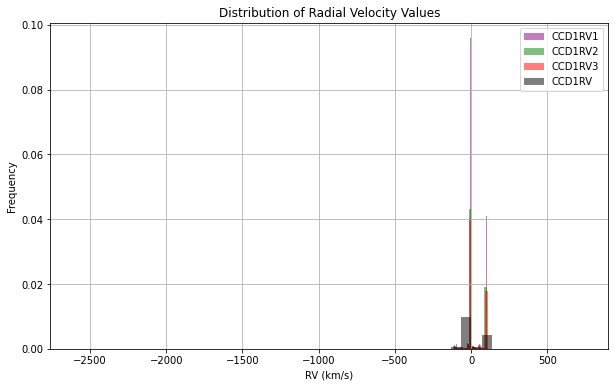

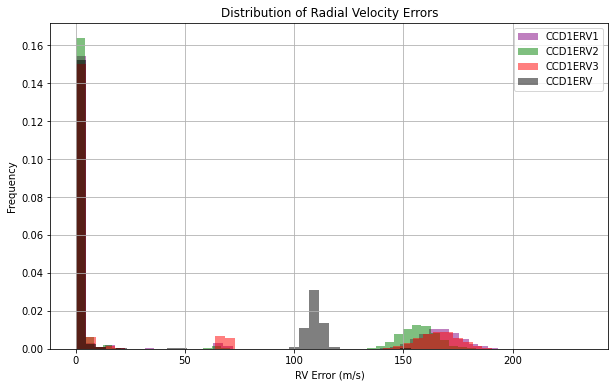

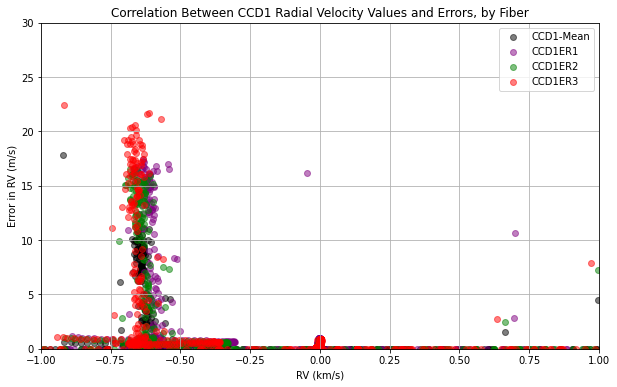

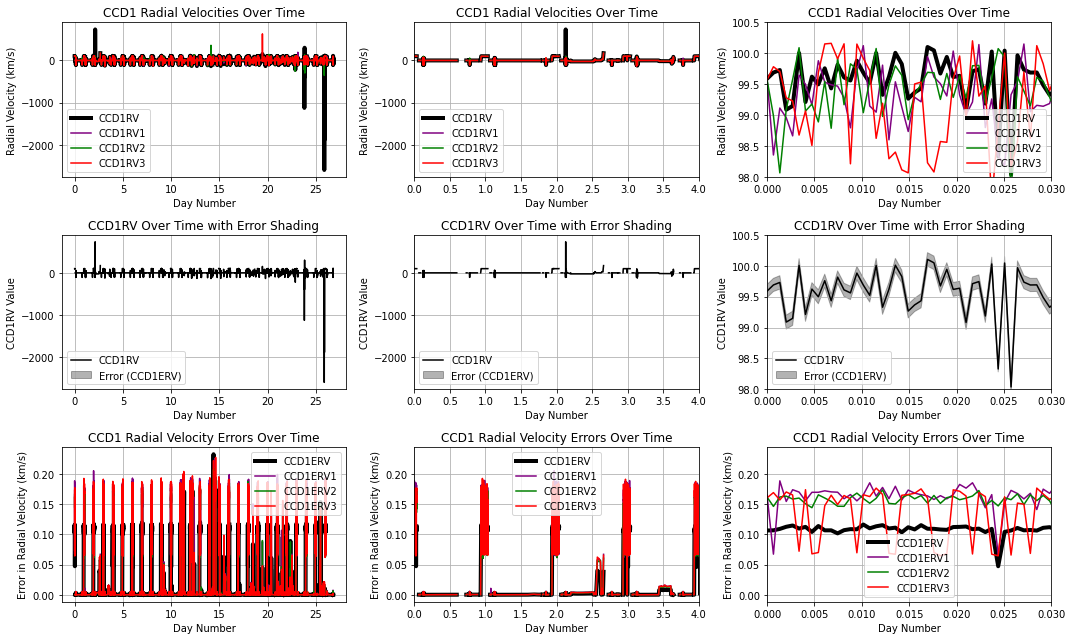

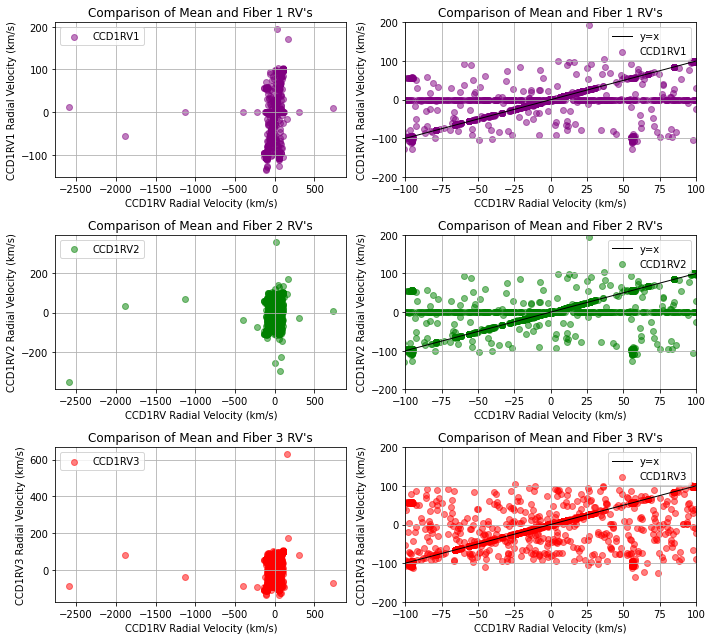

In [88]:
# plot the distributions of radial velocity values
plot_rv_value_histograms_by_fiber(df_02a)

# plot the distributions of radial velocity errors
plot_rv_error_histograms_by_fiber(df_02a)
# OBSERVATIONS:
#   the overall error is less than the error of each fiber (as expected)
#   the error distributions are different for the different fibers

# plot scatter of RV values and errors to explore possible correlations
plot_rv_error_scatter_by_fiber(df_02a, xmin=-1, xmax=1, ymin=0, ymax=30)
# OBSERVATIONS:
#   there is some clustering in the error 

# plot the mean RV value, along with its error, from the Green CCD over time
plot_rv_time_trends_grid(df_02a, 0, 0.03, 98, 100.5)
# OBSERVATIONS:
#   the error in RV varies over time (not a surprise)
# QUESTIONS:
#   how is the error itself computed?

# plot the mean RV against the component RV's
plot_rv_scatter_by_fiber(df_02a)
# OBSERVATIONS:
#   i'd naively expect a uniform distribution about y=x but we don't see this
#   howard mentioned that the error distribution around CCD1RV1=0 arises from the bias

### EDA - Etalon

In [89]:
# pass only objects that are etalon
df_02b= df_02a[df_02a['OBJECT'].str.contains('autocal-etalon')] # autocal-lfc # autocal-etalon

# inspect the df
display(df_02b.sample(3))

# display the df shape
print(f"DataFrame Shape: {df_02b.shape}")

,ObsID,OBJECT,datecode,CCD1BJD,day_num,NOTJUNK,GOODREAD,EMSAT,EMNEG,LOWBIAS,...,SNRCL652,SNRCL747,SNRCL852,SNRSK452,SNRSK548,SNRSK652,SNRSK747,SNRSK852,CCD1RV_upper,CCD1RV_lower
7512,KP.20241014.32543.79,autocal-etalon-all-night,20241014,2.460598e+06,13.376669,1.0,None,None,None,NaN,...,175.222,225.974,218.122,149.660,348.322,317.099,330.437,256.892,-0.007684,-0.007893
4749,KP.20241009.51302.59,autocal-etalon-all-night,20241009,2.460593e+06,8.591475,1.0,None,None,None,NaN,...,179.373,228.260,217.275,149.915,348.545,321.383,333.105,258.475,-0.006517,-0.006707
5313,KP.20241010.51523.85,autocal-etalon-all-night,20241010,2.460594e+06,9.595390,1.0,None,None,None,NaN,...,178.111,230.454,217.832,148.160,344.213,319.921,331.159,254.683,-0.007448,-0.007640


DataFrame Shape: (2538, 61)


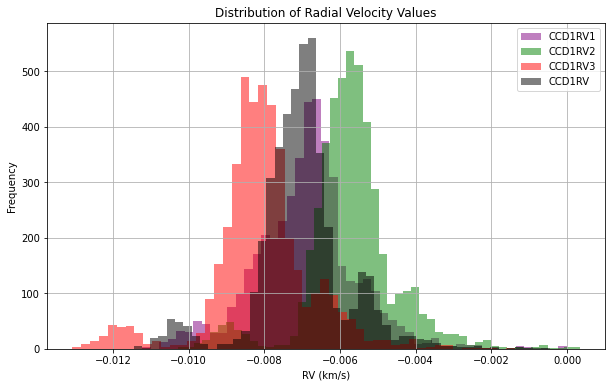

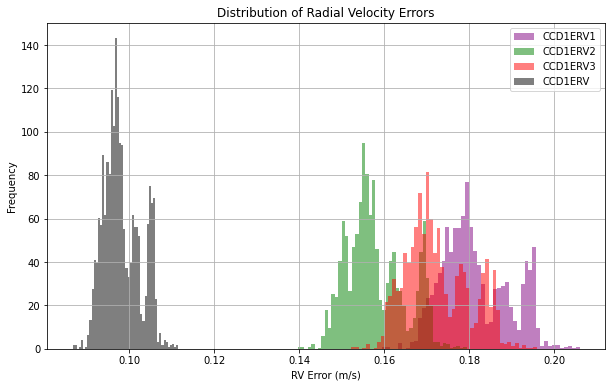

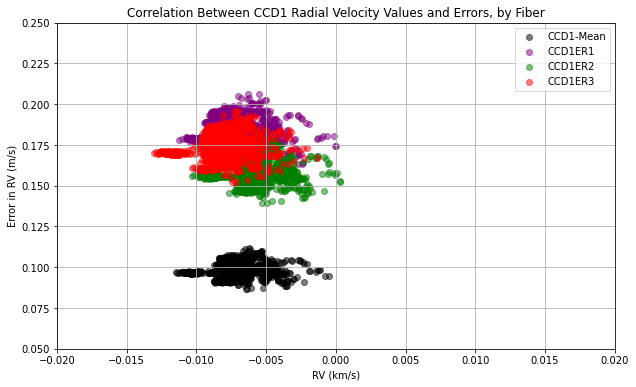

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


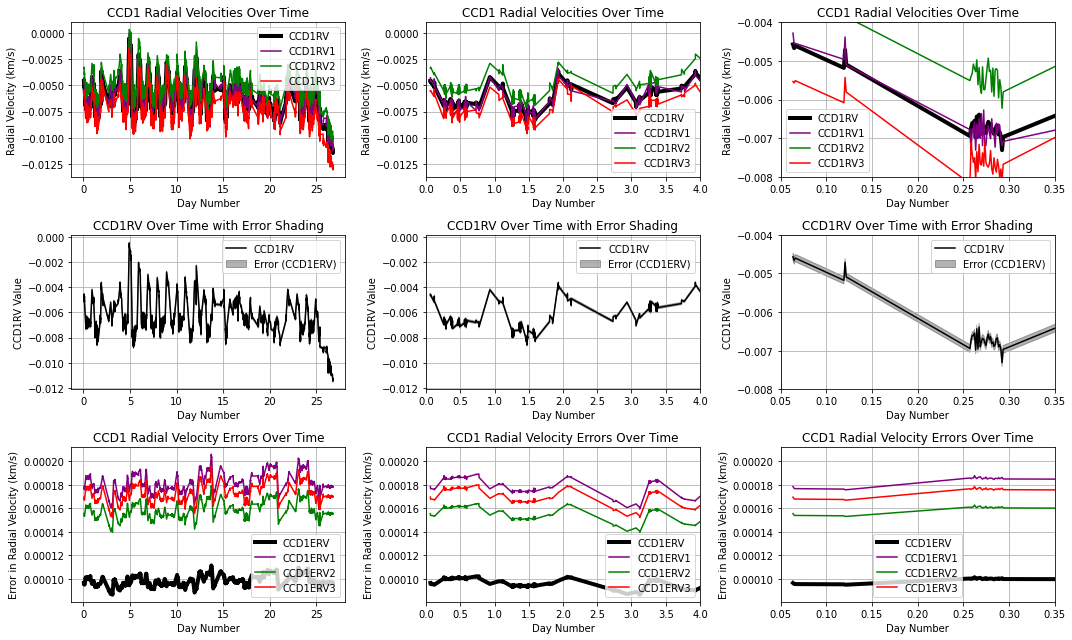

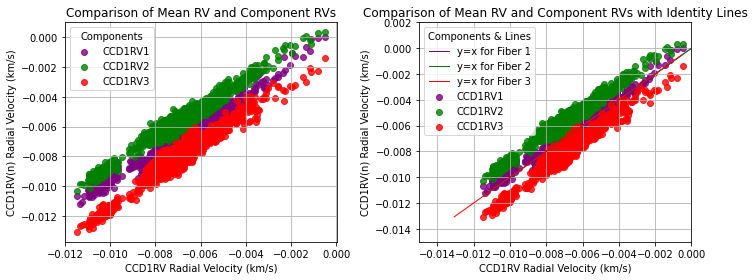

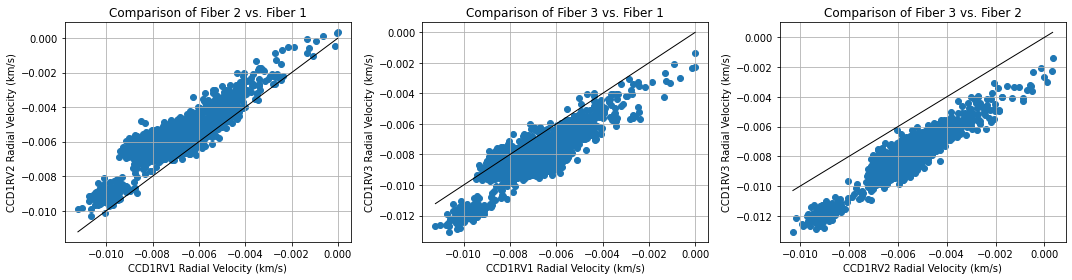

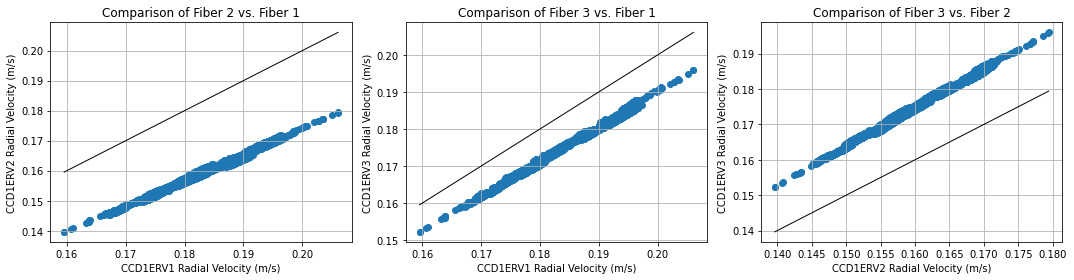

In [90]:
# plot the distributions of radial velocity values
plot_rv_value_histograms_by_fiber(df_02b)
# OBSERVATIONS:
#   why aren't the RV's centered about 0?

# plot the distributions of radial velocity errors
plot_rv_error_histograms_by_fiber(df_02b)
# OBSERVATIONS:
#   the overall error is ~ 0.1m/s, which is desired
#   the shape of the error distribution is not gaussian

# plot the distributions of radial velocity errors
plot_rv_error_scatter_by_fiber(df_02b, xmin=-.02, xmax=.02, ymin=0.05, ymax=.25)
# OBSERVATIONS:
#   there is some clustering in the error 

# investigate if there are any IQR outliers
"""show_iqr_outliers(df_02b, 'CCD1ERV')
show_iqr_outliers(df_02b, 'CCD1ERV1')
show_iqr_outliers(df_02b, 'CCD1ERV2')
show_iqr_outliers(df_02b, 'CCD1ERV3')"""

# perform t tests on errors from each error cluster
"""compare_rv_clusters_ttest(df_02b, 'CCD1ERV', 0.00025, 'CCD1ERV')
compare_rv_clusters_ttest(df_02b, 'CCD1ERV1', 0.00025, 'CCD1ERV1')
compare_rv_clusters_ttest(df_02b, 'CCD1ERV2', 0.00025, 'CCD1ERV2')
compare_rv_clusters_ttest(df_02b, 'CCD1ERV3', 0.00025, 'CCD1ERV3')"""

# perform t tests on temp from each error cluster
"""compare_rv_clusters(df_02b, 'CCD1ERV', 0.00025, 'ETAV1C1T')
compare_rv_clusters(df_02b, 'CCD1ERV1', 0.00025, 'ETAV1C1T')
compare_rv_clusters(df_02b, 'CCD1ERV2', 0.00025, 'ETAV1C1T')
compare_rv_clusters(df_02b, 'CCD1ERV3', 0.00025, 'ETAV1C1T')"""

# plot the mean RV value, along with its error, from the Green CCD over time
plot_rv_time_trends_grid(df_02b, 0.05, .35, -.008, -0.004)
# OBSERVATIONS:
#   the error in RV varies over time (not a surprise)
# QUESTIONS:
#   how is the error itself computed?

# plot the mean RV against the component RV's
#plot_rv_scatter_by_fiber(df_02b, -0.015,0,-0.015,0)
plot_rv_scatter_by_fiber_overlay(df_02b, -0.015,0,-0.015,0.002)
# OBSERVATIONS:
#   i'd naively expect a uniform distribution about y=x but we don't see this
#   howard mentioned that the error distribution around CCD1RV1=0 arises from the bias

# plot scatter of RV values between fibers
plot_fiber_rv_values_scatter(df_02b)
# OBSERVATIONS:
#   y-offset =/= 0

# plot scatter of RV errors between fibers
plot_fiber_rv_errors_scatter(df_02b)
# OBSERVATIONS:
#   y-offset =/= 0;  for Fiber1/Fiber2 the slope =/= 1

,SNRSC452,SNRSC548,SNRSC652,SNRSC747,SNRSC852
count,2536.000000,2536.000000,2536.000000,2536.000000,2536.000000
mean,280.421265,725.260262,762.165954,817.490556,623.528907
std,6.110248,11.780166,14.718652,10.001071,15.733817
min,262.340000,696.571000,729.722000,796.330000,586.582000
25%,278.434750,718.027750,751.938750,810.357000,609.495500
50%,281.859500,725.856000,759.952000,816.881500,630.212500
75%,283.922000,730.794000,766.694000,822.392500,634.952000
max,296.069000,765.831000,808.046000,850.440000,653.426000


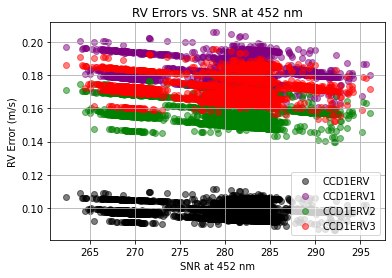

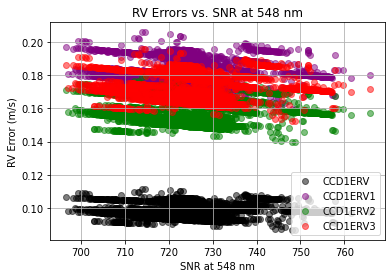

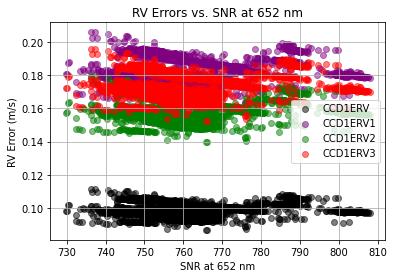

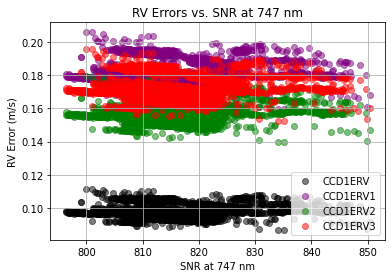

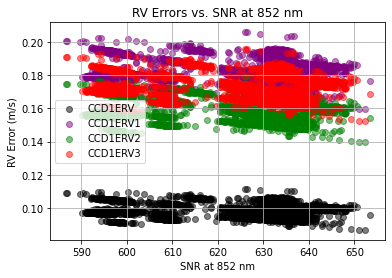

In [97]:
# inspect the SNR of the Science Fiber at 5 wavelengths
display(df_02b[['SNRSC452', 'SNRSC548', 'SNRSC652', 'SNRSC747', 'SNRSC852']].describe())

# plot the rv errors as a function of Science Fiber SNR for specified wavelengths
rv_error_cols = ['CCD1ERV', 'CCD1ERV1', 'CCD1ERV2', 'CCD1ERV3']
colors = ['black', 'purple', 'green', 'red']
plot_rv_errors_vs_snr_multiple(df_02b, 'SNRSC452', rv_error_cols, colors)
plot_rv_errors_vs_snr_multiple(df_02b, 'SNRSC548', rv_error_cols, colors)
plot_rv_errors_vs_snr_multiple(df_02b, 'SNRSC652', rv_error_cols, colors)
plot_rv_errors_vs_snr_multiple(df_02b, 'SNRSC747', rv_error_cols, colors)
plot_rv_errors_vs_snr_multiple(df_02b, 'SNRSC852', rv_error_cols, colors)

### EDA - LFC

In [92]:
# pass only objects that are lfc
df_02c= df_02a[df_02a['OBJECT'].str.contains('autocal-lfc')] # autocal-lfc # autocal-etalon

# inspect the df
display(df_02c.sample(3))

# display the df shape
print(f"DataFrame Shape: {df_02c.shape}")

,ObsID,OBJECT,datecode,CCD1BJD,day_num,NOTJUNK,GOODREAD,EMSAT,EMNEG,LOWBIAS,...,SNRCL652,SNRCL747,SNRCL852,SNRSK452,SNRSK548,SNRSK652,SNRSK747,SNRSK852,CCD1RV_upper,CCD1RV_lower
8036,KP.20241015.13000.96,autocal-lfc-all-eve,20241015,2.460599e+06,14.150170,1.0,None,None,None,NaN,...,326.005,247.053,455.329,0.0,740.441,623.039,568.812,703.368,0.137122,0.137104
10222,KP.20241019.12180.97,autocal-lfc-all-eve,20241019,2.460603e+06,18.140513,1.0,None,None,None,NaN,...,292.276,234.561,482.639,0.0,617.152,556.149,537.569,743.559,0.136897,0.136878
5873,KP.20241011.67551.37,autocal-lfc-all-morn,20241011,2.460595e+06,10.781662,1.0,None,None,None,NaN,...,308.135,239.666,476.224,0.0,653.890,583.981,550.958,739.058,0.136817,0.136799


DataFrame Shape: (578, 61)


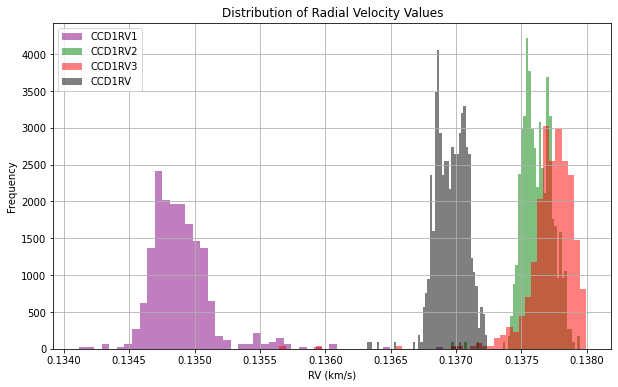

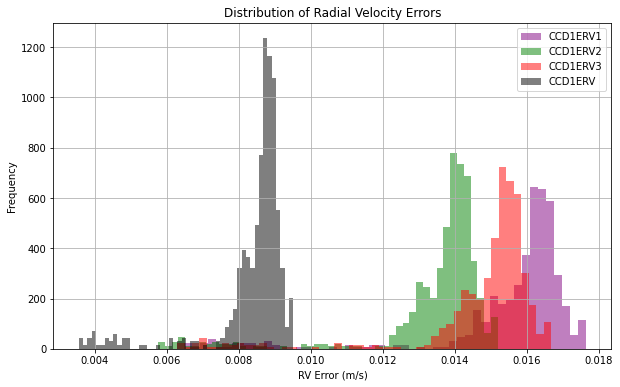

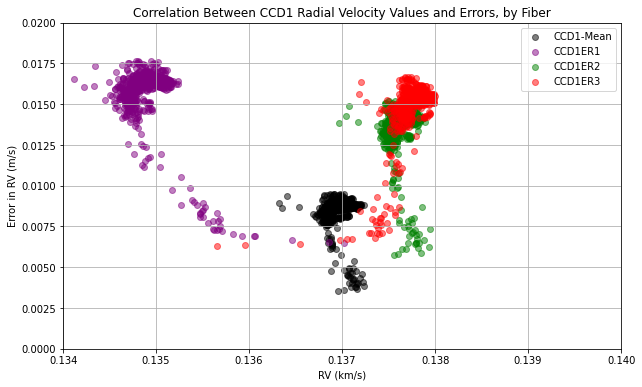

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


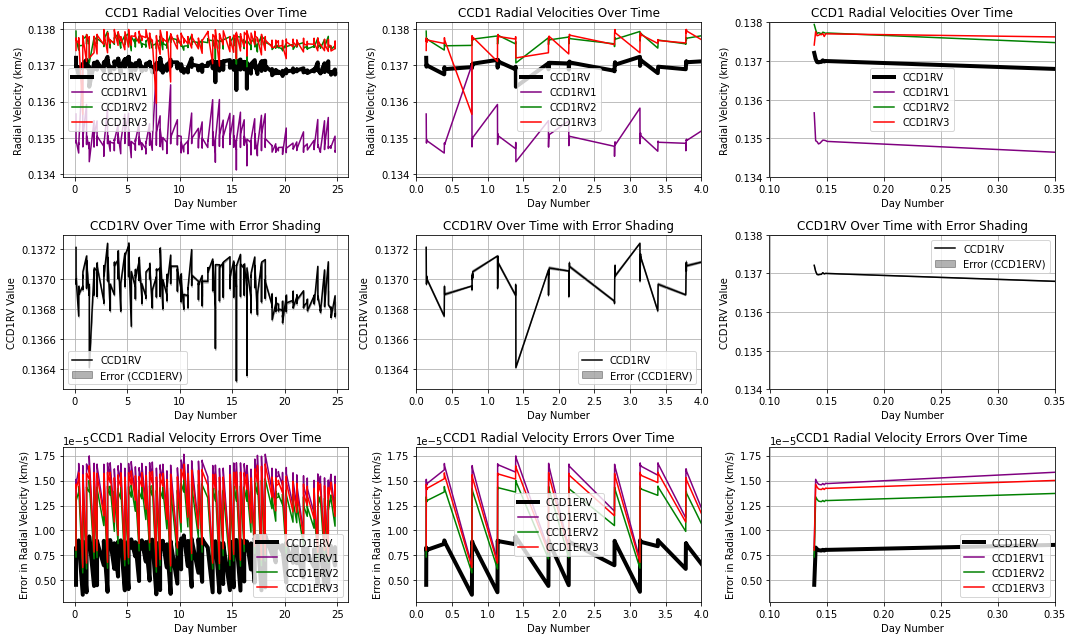

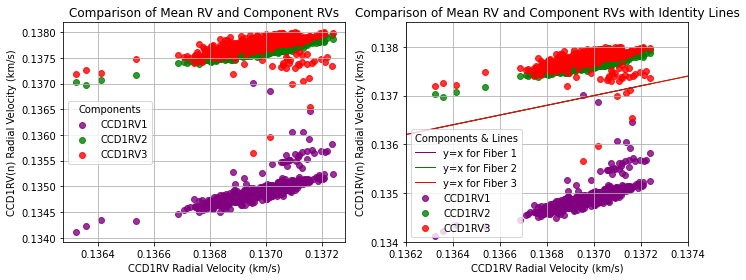

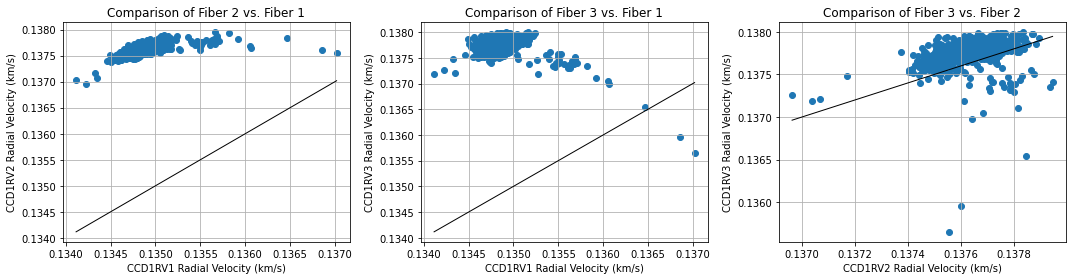

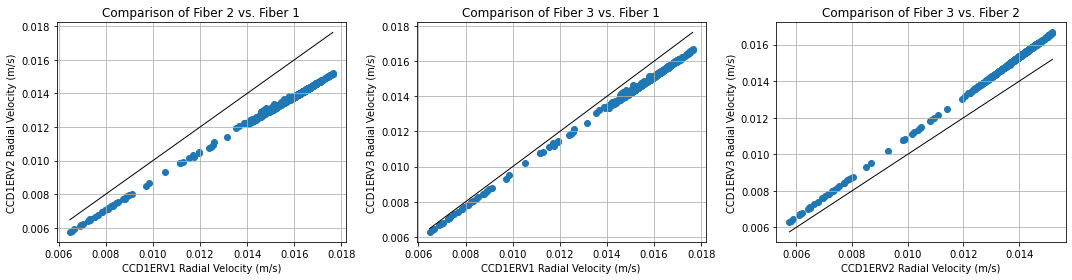

In [93]:
# plot the distributions of radial velocity values
plot_rv_value_histograms_by_fiber(df_02c)

# plot the distributions of radial velocity errors
plot_rv_error_histograms_by_fiber(df_02c)
# OBSERVATIONS:
#   why aren't the RV's centered around 0 (some neg, some pos)?

# plot the distributions of radial velocity errors
plot_rv_error_scatter_by_fiber(df_02c, xmin=.134, xmax=.14, ymin=0, ymax=.02)
# OBSERVATIONS:
#   there is some clustering in the error 

# investigate if there are any IQR outliers
"""show_iqr_outliers(df_02c, 'CCD1ERV')
show_iqr_outliers(df_02c, 'CCD1ERV1')
show_iqr_outliers(df_02c, 'CCD1ERV2')
show_iqr_outliers(df_02c, 'CCD1ERV3')"""

# perform t tests on errors from each error cluster
"""compare_rv_clusters_ttest(df_02c, 'CCD1ERV', 0.00025, 'CCD1ERV')
compare_rv_clusters_ttest(df_02c, 'CCD1ERV1', 0.00025, 'CCD1ERV1')
compare_rv_clusters_ttest(df_02c, 'CCD1ERV2', 0.00025, 'CCD1ERV2')
compare_rv_clusters_ttest(df_02c, 'CCD1ERV3', 0.00025, 'CCD1ERV3')"""

# perform t tests on temp from each error cluster
"""compare_rv_clusters(df_02c, 'CCD1ERV', 0.00025, 'ETAV1C1T')
compare_rv_clusters(df_02c, 'CCD1ERV1', 0.00025, 'ETAV1C1T')
compare_rv_clusters(df_02c, 'CCD1ERV2', 0.00025, 'ETAV1C1T')
compare_rv_clusters(df_02c, 'CCD1ERV3', 0.00025, 'ETAV1C1T')"""

# plot the mean RV value, along with its error, from the Green CCD over time
plot_rv_time_trends_grid(df_02c, 0.1, .35, 0.134, 0.138)
# OBSERVATIONS:
#   the error in RV varies over time (not a surprise)
# QUESTIONS:
#   how is the error itself computed?

# plot the mean RV against the component RV's
#plot_rv_scatter_by_fiber(df_02c, 0.1362,0.1374,0.134,0.138)
plot_rv_scatter_by_fiber_overlay(df_02c, 0.1362,0.1374,0.134,0.1385)
# OBSERVATIONS:
#   i'd naively expect a uniform distribution about y=x but we don't see this
#   howard mentioned that the error distribution around CCD1RV1=0 arises from the bias

# plot scatter of RV values between fibers
plot_fiber_rv_values_scatter(df_02c)
# OBSERVATIONS:
#   y-offset =/= 0

# plot scatter of RV errors between fibers
plot_fiber_rv_errors_scatter(df_02c)
# OBSERVATIONS:
#   y-offset =/= 0;  for Fiber1/Fiber2 the slope =/= 1

,SNRSC452,SNRSC548,SNRSC652,SNRSC747,SNRSC852
count,519.000000,519.000000,519.000000,519.000000,519.000000
mean,-19.515385,1069.833736,1088.213805,1008.184372,960.327266
std,0.598417,40.752306,31.942002,20.144567,18.458037
min,-20.988000,950.309000,993.286000,944.184000,919.921000
25%,-19.913000,1042.965500,1069.407500,995.351000,946.591500
50%,-19.527000,1072.130000,1089.544000,1007.107000,961.088000
75%,-19.151000,1100.042500,1107.832000,1019.778500,972.806000
max,-17.717000,1159.333000,1177.410000,1060.552000,1015.283000


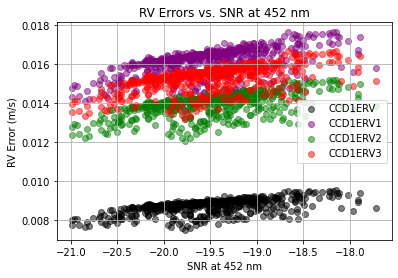

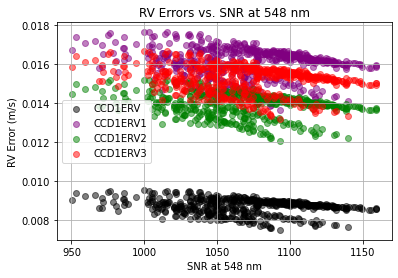

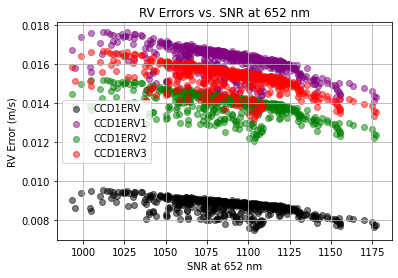

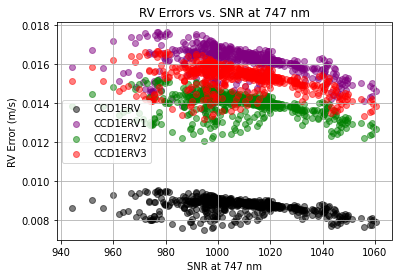

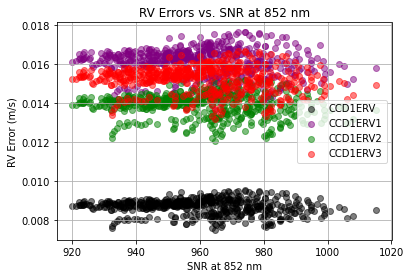

In [102]:
# inspect the SNR of the Science Fiber at 5 wavelengths
display(df_02c[['SNRSC452', 'SNRSC548', 'SNRSC652', 'SNRSC747', 'SNRSC852']].describe())

# plot the rv errors as a function of Science Fiber SNR for specified wavelengths
rv_error_cols = ['CCD1ERV', 'CCD1ERV1', 'CCD1ERV2', 'CCD1ERV3']
colors = ['black', 'purple', 'green', 'red']
plot_rv_errors_vs_snr_multiple(df_02c, 'SNRSC452', rv_error_cols, colors)
plot_rv_errors_vs_snr_multiple(df_02c, 'SNRSC548', rv_error_cols, colors)
plot_rv_errors_vs_snr_multiple(df_02c, 'SNRSC652', rv_error_cols, colors)
plot_rv_errors_vs_snr_multiple(df_02c, 'SNRSC747', rv_error_cols, colors)
plot_rv_errors_vs_snr_multiple(df_02c, 'SNRSC852', rv_error_cols, colors)

In [101]:
# apply filter to keep data only in linear region with 
df_02c = df_02c[
    (df_02c['SNRSC452'] >= -22) &
    (df_02c['SNRSC548'] <= 1250) &
    (df_02c['SNRSC652'] <= 1250) &
    (df_02c['SNRSC747'] <= 1100) &
    (df_02c['SNRSC852'] <= 1025)
]

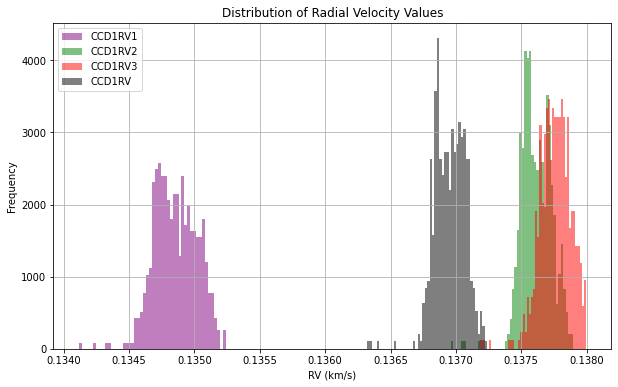

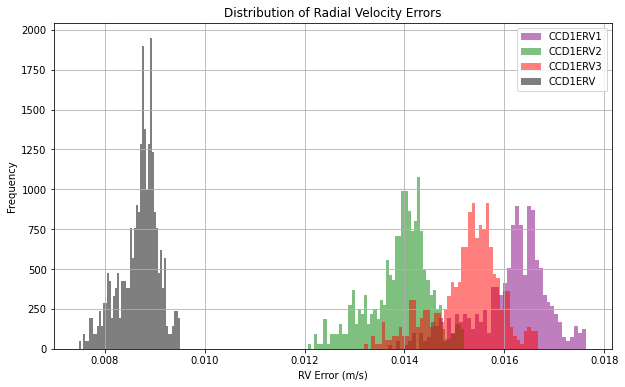

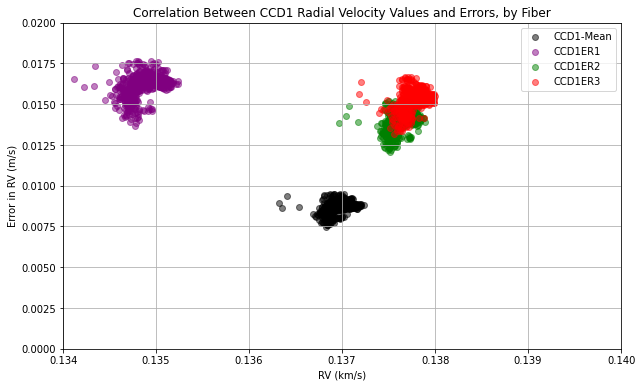

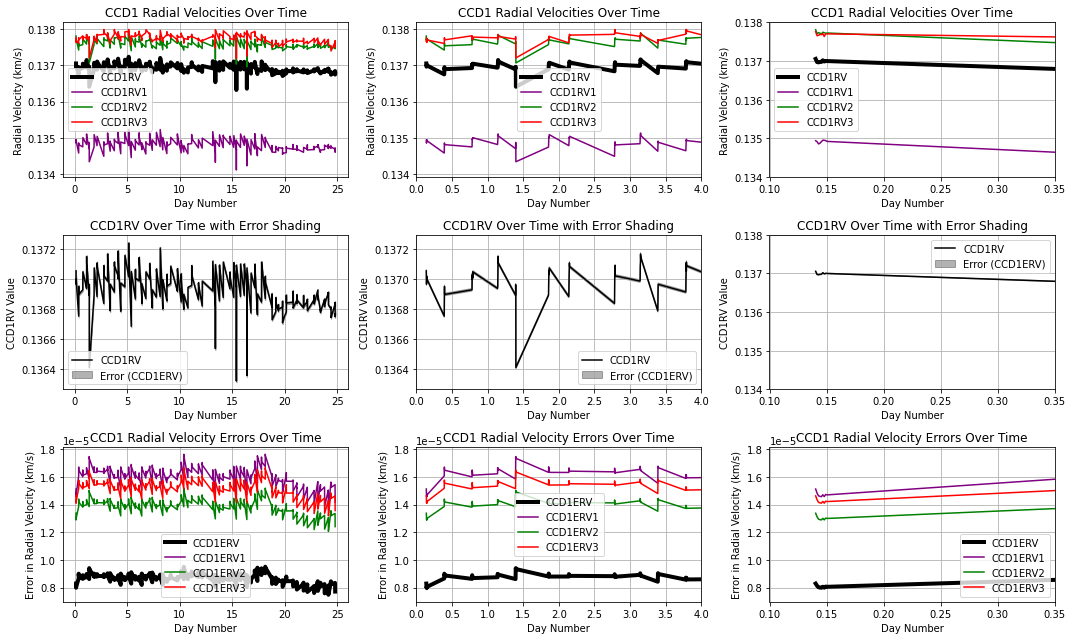

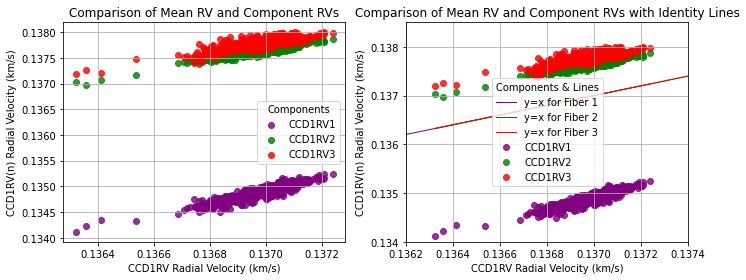

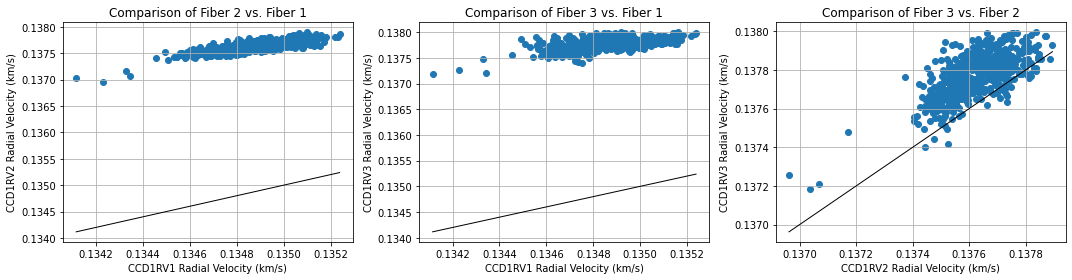

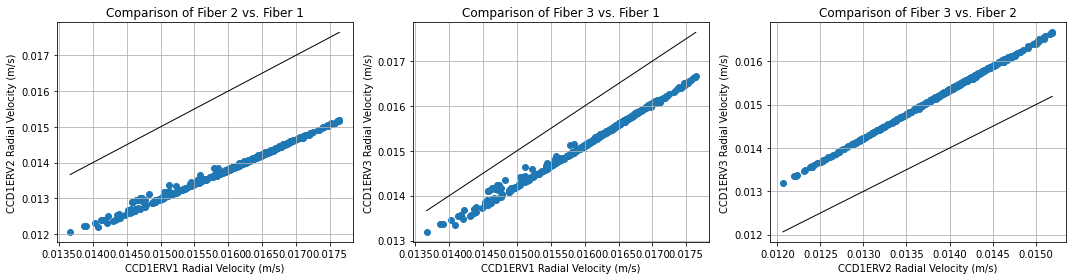

In [103]:
# plot the distributions of radial velocity values
plot_rv_value_histograms_by_fiber(df_02c)

# plot the distributions of radial velocity errors
plot_rv_error_histograms_by_fiber(df_02c)
# OBSERVATIONS:
#   why aren't the RV's centered around 0 (some neg, some pos)?

# plot the distributions of radial velocity errors
plot_rv_error_scatter_by_fiber(df_02c, xmin=.134, xmax=.14, ymin=0, ymax=.02)
# OBSERVATIONS:
#   there is some clustering in the error 

# investigate if there are any IQR outliers
"""show_iqr_outliers(df_02c, 'CCD1ERV')
show_iqr_outliers(df_02c, 'CCD1ERV1')
show_iqr_outliers(df_02c, 'CCD1ERV2')
show_iqr_outliers(df_02c, 'CCD1ERV3')"""

# perform t tests on errors from each error cluster
"""compare_rv_clusters_ttest(df_02c, 'CCD1ERV', 0.00025, 'CCD1ERV')
compare_rv_clusters_ttest(df_02c, 'CCD1ERV1', 0.00025, 'CCD1ERV1')
compare_rv_clusters_ttest(df_02c, 'CCD1ERV2', 0.00025, 'CCD1ERV2')
compare_rv_clusters_ttest(df_02c, 'CCD1ERV3', 0.00025, 'CCD1ERV3')"""

# perform t tests on temp from each error cluster
"""compare_rv_clusters(df_02c, 'CCD1ERV', 0.00025, 'ETAV1C1T')
compare_rv_clusters(df_02c, 'CCD1ERV1', 0.00025, 'ETAV1C1T')
compare_rv_clusters(df_02c, 'CCD1ERV2', 0.00025, 'ETAV1C1T')
compare_rv_clusters(df_02c, 'CCD1ERV3', 0.00025, 'ETAV1C1T')"""

# plot the mean RV value, along with its error, from the Green CCD over time
plot_rv_time_trends_grid(df_02c, 0.1, .35, 0.134, 0.138)
# OBSERVATIONS:
#   the error in RV varies over time (not a surprise)
# QUESTIONS:
#   how is the error itself computed?

# plot the mean RV against the component RV's
#plot_rv_scatter_by_fiber(df_02c, 0.1362,0.1374,0.134,0.138)
plot_rv_scatter_by_fiber_overlay(df_02c, 0.1362,0.1374,0.134,0.1385)
# OBSERVATIONS:
#   i'd naively expect a uniform distribution about y=x but we don't see this
#   howard mentioned that the error distribution around CCD1RV1=0 arises from the bias

# plot scatter of RV values between fibers
plot_fiber_rv_values_scatter(df_02c)
# OBSERVATIONS:
#   y-offset =/= 0

# plot scatter of RV errors between fibers
plot_fiber_rv_errors_scatter(df_02c)
# OBSERVATIONS:
#   y-offset =/= 0;  for Fiber1/Fiber2 the slope =/= 1

,SNRSC452,SNRSC548,SNRSC652,SNRSC747,SNRSC852
count,519.000000,519.000000,519.000000,519.000000,519.000000
mean,-19.515385,1069.833736,1088.213805,1008.184372,960.327266
std,0.598417,40.752306,31.942002,20.144567,18.458037
min,-20.988000,950.309000,993.286000,944.184000,919.921000
25%,-19.913000,1042.965500,1069.407500,995.351000,946.591500
50%,-19.527000,1072.130000,1089.544000,1007.107000,961.088000
75%,-19.151000,1100.042500,1107.832000,1019.778500,972.806000
max,-17.717000,1159.333000,1177.410000,1060.552000,1015.283000


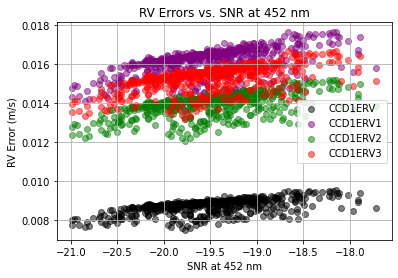

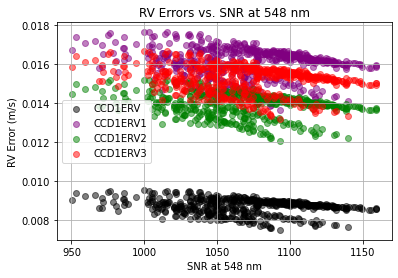

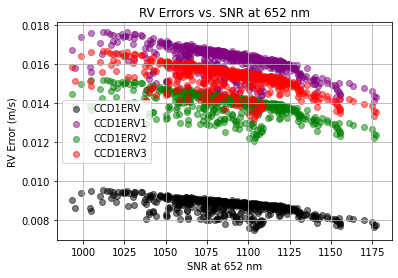

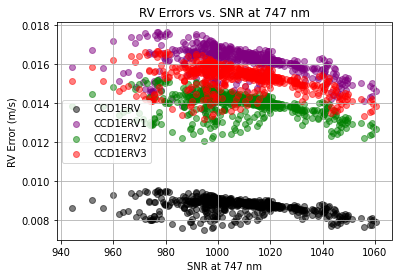

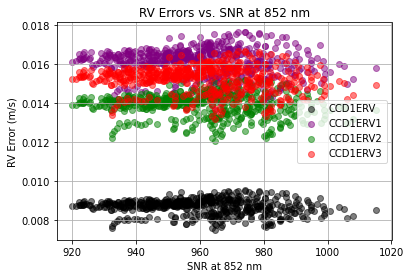

In [104]:
# inspect the SNR of the Science Fiber at 5 wavelengths
display(df_02c[['SNRSC452', 'SNRSC548', 'SNRSC652', 'SNRSC747', 'SNRSC852']].describe())

# plot the rv errors as a function of Science Fiber SNR for specified wavelengths
rv_error_cols = ['CCD1ERV', 'CCD1ERV1', 'CCD1ERV2', 'CCD1ERV3']
colors = ['black', 'purple', 'green', 'red']
plot_rv_errors_vs_snr_multiple(df_02c, 'SNRSC452', rv_error_cols, colors)
plot_rv_errors_vs_snr_multiple(df_02c, 'SNRSC548', rv_error_cols, colors)
plot_rv_errors_vs_snr_multiple(df_02c, 'SNRSC652', rv_error_cols, colors)
plot_rv_errors_vs_snr_multiple(df_02c, 'SNRSC747', rv_error_cols, colors)
plot_rv_errors_vs_snr_multiple(df_02c, 'SNRSC852', rv_error_cols, colors)

## Provisional